In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # other options: tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

2024-09-17 12:53:32.311574: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-17 12:53:32.526779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 12:53:32.607428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 12:53:32.629968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 12:53:32.787562: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.17.0
Keras: 3.5.0
KerasCV: 0.9.0


⚙️ | Configuration

In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    neg_sample = 0.01 # Downsample negative class
    pos_sample = 5.0  # Upsample positive class
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [128, 128]  # Input image size
    epochs = 8 # Training epochs
    batch_size = 256  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    class_names = ['target']
    num_classes = 1

♻️ | Reproducibility

Sets value for random seed to produce similar result in each run.

In [4]:
keras.utils.set_random_seed(CFG.seed)

📁 | Dataset Path 

In [5]:
BASE_PATH = "/home/teng/dev/projects/public/skin-cancer-detection/datasets"
# "/kaggle/input/isic-2024-challenge"

📖 | Meta Data
In this dataset, following information is available:

train-image/: Contains image files for the training set (provided for train only).
train-image.hdf5: Training image data stored in a single HDF5 file, where each image is indexed by its isic_id.
train-metadata.csv: Metadata corresponding to the training set, including:
isic_id: Unique image ID used to query images in the HDF5 file.
patient_id: Unique patient ID.
sex: Gender of the patient.
age_approx: Approximate age of the patient.
anatom_site_general: Location of the lesion.
Other relevant metadata fields.
test-image.hdf5: Testing image data stored in a single HDF5 file, initially containing 3 testing examples to validate the inference pipeline. Upon notebook submission, this file is replaced with the full hidden testing set, which contains approximately 500,000 images.
test-metadata.csv: Metadata corresponding to the testing subset.

In [6]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')
df = df.ffill()
display(df.head(2))

# Testing
testing_df = pd.read_csv(f'{BASE_PATH}/test-metadata.csv')
testing_df = testing_df.ffill()
display(testing_df.head(2))

/tmp/ipykernel_41835/4057045618.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


⚖️ | Handle Class Imbalance

Sample Data

There is a significant class imbalance in the dataset, with a large number of negative samples compared to positive samples. To address this issue, the negative class will be downsampled and upsample the positive class. To experiment with full dataset, simply adjust the pos_sample and neg_sample settings in CFG.

In [7]:
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Sampling
positive_df = df.query("target==0").sample(frac=CFG.neg_sample, random_state=CFG.seed)
negative_df = df.query("target==1").sample(frac=CFG.pos_sample, replace=True, random_state=CFG.seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

Class Distribution Before Sampling (%):


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


Class Distribution After Sampling (%):


target
0    67.09645
1    32.90355
Name: proportion, dtype: float64

In [12]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

Class Weight

Even after downsampling the negative class and upsampling the positive class, there remains a significant class imbalance. To further address this imbalance during training, loss weighting will be used. This technique ensures that the model weights are updated more heavily for the positive samples, thereby reducing the bias towards the negative class. The following code computes the class weights for the loss:

In [8]:
# !pip install scikit-learn

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


🖼️ | Load Image Byte String¶

In this competition, images are provided as byte strings. The following code snippet demonstrates how to load these images into memory. One might wonder why the provided jpeg images aren't being used in the /train-image folder for training. This is because testing images are not provided as JPEG images; instead, they are provided as byte strings. Why use byte strings? They occupy significantly less memory compared to np.array representations.

In [9]:
import h5py

training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{BASE_PATH}/test-image.hdf5", 'r')

In [14]:
df.count()

isic_id                         5972
target                          5972
patient_id                      5972
age_approx                      5972
sex                             5972
anatom_site_general             5972
clin_size_long_diam_mm          5972
image_type                      5972
tbp_tile_type                   5972
tbp_lv_A                        5972
tbp_lv_Aext                     5972
tbp_lv_B                        5972
tbp_lv_Bext                     5972
tbp_lv_C                        5972
tbp_lv_Cext                     5972
tbp_lv_H                        5972
tbp_lv_Hext                     5972
tbp_lv_L                        5972
tbp_lv_Lext                     5972
tbp_lv_areaMM2                  5972
tbp_lv_area_perim_ratio         5972
tbp_lv_color_std_mean           5972
tbp_lv_deltaA                   5972
tbp_lv_deltaB                   5972
tbp_lv_deltaL                   5972
tbp_lv_deltaLB                  5972
tbp_lv_deltaLBnorm              5972
t

Check Image

Examining a sample image from the provided data is important. This step allows for a closer inspection of the image quality and content, ensuring it meets the requirements for further processing.

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image:


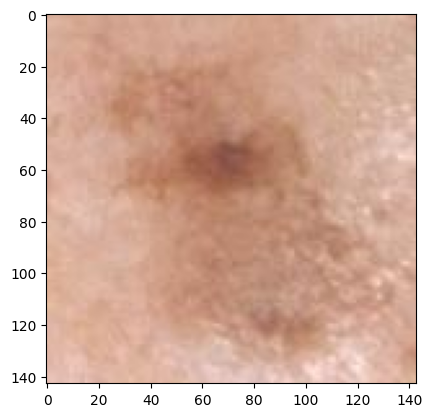

In [18]:
isic_id = df.isic_id.iloc[0]

# Image as Byte String
byte_string = training_validation_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

# Convert byte string to numpy array
nparr = np.frombuffer(byte_string, np.uint8)

print("Image:")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
plt.imshow(image);

🔪 | Data Split¶

In the following code,the data will be splitted into 5 stratified folds and use the first fold for training and validation. It's important to note that StratifiedGroupKFold is being used to ensure that patient_ids do not overlap between the training and validation datasets. This prevents data leakage, where the model could potentially peak at data it should not have access to.

**Note:** Data leakage can lead to artificially high validation scores that do not reflect real-world performance.

In [11]:
from sklearn.model_selection import StratifiedGroupKFold

df = df.reset_index(drop=True) # ensure continuous index
df["fold"] = -1
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[validation_idx, "fold"] = int(i)

# Use first fold for training and validation
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")
print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4706 | Num Valid: 1266


In [23]:
# Class Distribution in Training
training_df.target.value_counts()

target
0    3088
1    1618
Name: count, dtype: int64

In [24]:
# Class Distribution in Validation
validation_df.target.value_counts()

target
0    919
1    347
Name: count, dtype: int64

📊 | Tabular Features

In this competition, alongside image data, tabular features such as age, sex, and the location of the lesion are available. Previous competitions, like ISIC 2020, have demonstrated that incorporating these tabular features can significantly enhance model performance. A similar improvement is anticipated here.

The following code snippet provides a method for selecting which tabular features to include. It is encouraged to experiment with various combinations to determine the most effective set.

In [25]:
# Categorical features which will be one hot encoded
CATEGORICAL_COLUMNS = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", ]

# Numeraical features which will be normalized
NUMERIC_COLUMNS = ["age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
           "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
           "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM", ]

# Tabular feature columns
FEAT_COLS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5972 entries, 0 to 5971
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   isic_id                       5972 non-null   object 
 1   target                        5972 non-null   int64  
 2   patient_id                    5972 non-null   object 
 3   age_approx                    5972 non-null   float64
 4   sex                           5972 non-null   object 
 5   anatom_site_general           5972 non-null   object 
 6   clin_size_long_diam_mm        5972 non-null   float64
 7   image_type                    5972 non-null   object 
 8   tbp_tile_type                 5972 non-null   object 
 9   tbp_lv_A                      5972 non-null   float64
 10  tbp_lv_Aext                   5972 non-null   float64
 11  tbp_lv_B                      5972 non-null   float64
 12  tbp_lv_Bext                   5972 non-null   float64
 13  tbp

🍚 | DataLoader

This DataLoader is designed to process both images and tabular features simultaneously as inputs. It applies augmentations like flip and cutout, with additional options available such as random brightness, contrast, zoom, and rotation. Experimentation with different augmentations is encouraged. More details on the available augmentations in KerasCV can be found here.

**Note:** Unlike standard augmentations, these augmentations are applied to a batch, enhancing training speed and reducing CPU bottlenecks.

In [15]:
def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
    ]
    
    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, CFG.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    isic_ids,
    hdf5,
    features,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    images = [None]*len(isic_ids)
    for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading Images ")):
        images[i] = hdf5[isic_id][()]
        
    inp = {"images": images, "features": features}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

Build Training & Validation Dataset

In the following code, training and validation data loaders will be created.

In [16]:
## Train
print("# Training:")
training_features = dict(training_df[FEAT_COLS])
training_ids = training_df.isic_id.values
training_labels = training_df.target.values
training_ds = build_dataset(training_ids, training_validation_hdf5, training_features, 
                         training_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=True)

# Valid
print("# Validation:")
validation_features = dict(validation_df[FEAT_COLS])
validation_ids = validation_df.isic_id.values
validation_labels = validation_df.target.values
validation_ds = build_dataset(validation_ids, training_validation_hdf5, validation_features,
                         validation_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

# Training:


I0000 00:00:1726502839.548455  209845 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-16 19:07:19.755209: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

In [17]:
feature_space = keras.utils.FeatureSpace(
    features={
        # Categorical features encoded as integers
        "sex": "string_categorical",
        "anatom_site_general": "string_categorical",
        "tbp_tile_type": "string_categorical",
        "tbp_lv_location": "string_categorical",
        # Numerical features to discretize
        "age_approx": "float_discretized",
        # Numerical features to normalize
        "tbp_lv_nevi_confidence": "float_normalized",
        "clin_size_long_diam_mm": "float_normalized",
        "tbp_lv_areaMM2": "float_normalized",
        "tbp_lv_area_perim_ratio": "float_normalized",
        "tbp_lv_color_std_mean": "float_normalized",
        "tbp_lv_deltaLBnorm": "float_normalized",
        "tbp_lv_minorAxisMM": "float_normalized",
    },
    output_mode="concat",
)

Configuring a FeatureSpace

To set up how each tabular feature should be preprocessed, keras.utils.FeatureSpace is used. A dictionary is passsed to it that maps each feature name to a string describing its type.

  - String Categorical Features:
    - Examples: sex, anotm_site_general

  - Numerical Features:
    - Examples: tbp_lv_nevi_confidence, clin_size_long_diam_mm
    - Note: These features will be normalized.
  
  - Numerical Discrete Features:
    - age_approx: Need to discretize this feature into a number of bins.

Adapt Tabular Features

Before the FeatureSpace is used to build a model, it needs to be adapted to the training data. During adapt(), the FeatureSpace will:

- Index the set of possible values for categorical features.
- Compute the mean and variance for numerical features to normalize.
- Compute the value boundaries for the different bins for numerical features to discretize.

Note: adapt() should be called on a tf.data.Dataset that yields dictionaries of feature values – no labels.

In [18]:
training_ds_with_no_labels = training_ds.map(lambda x, _: x["features"])
feature_space.adapt(training_ds_with_no_labels)


2024-09-16 19:07:33.648726: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-16 19:07:33.655320: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-16 19:07:34.440936: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-16 19:07:35.925841: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-16 19:07:38.741620: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with st

At this point, the `FeatureSpace` can be called on a dictionary of raw feature values. It will return a single concatenated vector for each sample, combining encoded features.

In the code below, it can be noticed that even though `12` raw (tabular) features are used, after processing with `FeatureSpace`, a vector of size `71` is created. This is because operations like one-hot encoding are being applied here.

In [19]:
for x, _ in training_ds.take(1):
    preprocessed_x = feature_space(x["features"])
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (256, 71)
preprocessed_x.dtype: <dtype: 'float32'>


Apply Feature Processing

Integrating feature space processing into the data pipeline before the model is crucial. This approach enables asynchronous, parallel preprocessing of data on the CPU, ensuring it is optimized before being fed into the model.

In [20]:
training_ds = training_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

validation_ds = validation_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

Output Shape of a Batch

Verifying the shape of a batch sample is essential. This step ensures that the dataloader is generating inputs with the correct dimensions, which is critical for the model's performance.

In [21]:
batch = next(iter(validation_ds))

print("Images:",batch[0]["images"].shape)
print("Features:", batch[0]["features"].shape)
print("Targets:", batch[1].shape)

Images: (256, 128, 128, 3)
Features: (256, 71)
Targets: (256, 1)


2024-09-16 19:08:45.556376: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset Check

Visualizing samples along with their associated labels from the dataset is a vital step. This process helps in understanding the data distribution and ensures that the dataset is correctly labeled.

🔍 | Loss & Metric

This competition utilizes the Partial Area Under the Curve (pAUC) metric for evaluation. In Keras, a similar metric is ROC AUC, which can be used for approximate evaluation. For optimizing our model, binary cross entropy (BCE) loss from Keras will be used.

It's important to note that BCE loss is sensitive to class imbalance. To mitigate this issue, the class weights will be used which is computed earlier. These weights will prioritize updating the model weights more strongly for the minority class (positive class), thereby mitigating class imbalance.

In [22]:
# AUC
auc = keras.metrics.AUC()

# Loss
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.02)

🤖 | Modeling

In this notebook, we're using the EfficientNetV2 B2 backbone from KerasCV's pretrained models to extract features from images. For processing tabular data, Dense layers are used. The final layer (head) is a Dense layer with a sigmoid activation function. The sigmoid activation is chosen because the target is binary; softmax would've been selected if the target was multiclass.

To explore other backbones, one can simply modify the preset in the CFG (config). A list of available pretrained backbones can be found on the KerasCV website.

**Note:** Since the size of tabular features likely to change due to feature space processing, `feature_space.get_encoded_features()` is used to determine the final size of the tabular feature vector for building the model.

In [23]:
# Define input layers
image_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
feat_input = keras.Input(shape=(feature_space.get_encoded_features().shape[1],), name="features")
inp = {"images":image_input, "features":feat_input}

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(image_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Branch for tabular/feature input
x2 = keras.layers.Dense(96, activation="selu")(feat_input)
x2 = keras.layers.Dense(128, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(concat)

# Build model
model = keras.models.Model(inp, out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=[auc],
)

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2b2… │ (None, 4, 4,      │  8,769,374 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1408)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,416 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1408)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1536)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      1,537 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,790,239 (33.53 MB)

 Trainable params: 8,707,951 (33.22 MB)

 Non-trainable params: 82,288 (321.44 KB)

Plot Model

As our model is multi-input, it is difficult to understand what is going on inside the architecture. That is where plot_model from Keras can be very handy. Overall architecture is shown, making it easier to design or recheck our architecture.

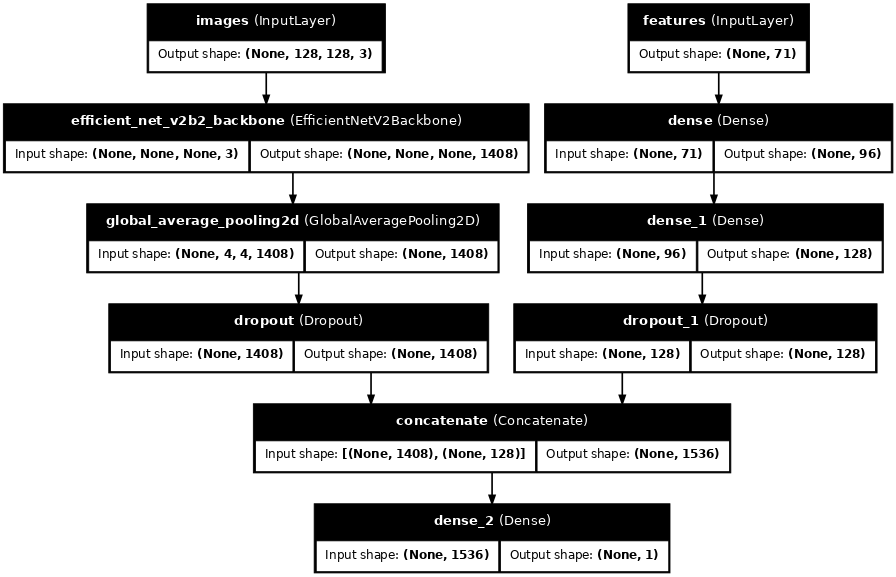

In [24]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

⚓ | LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [25]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

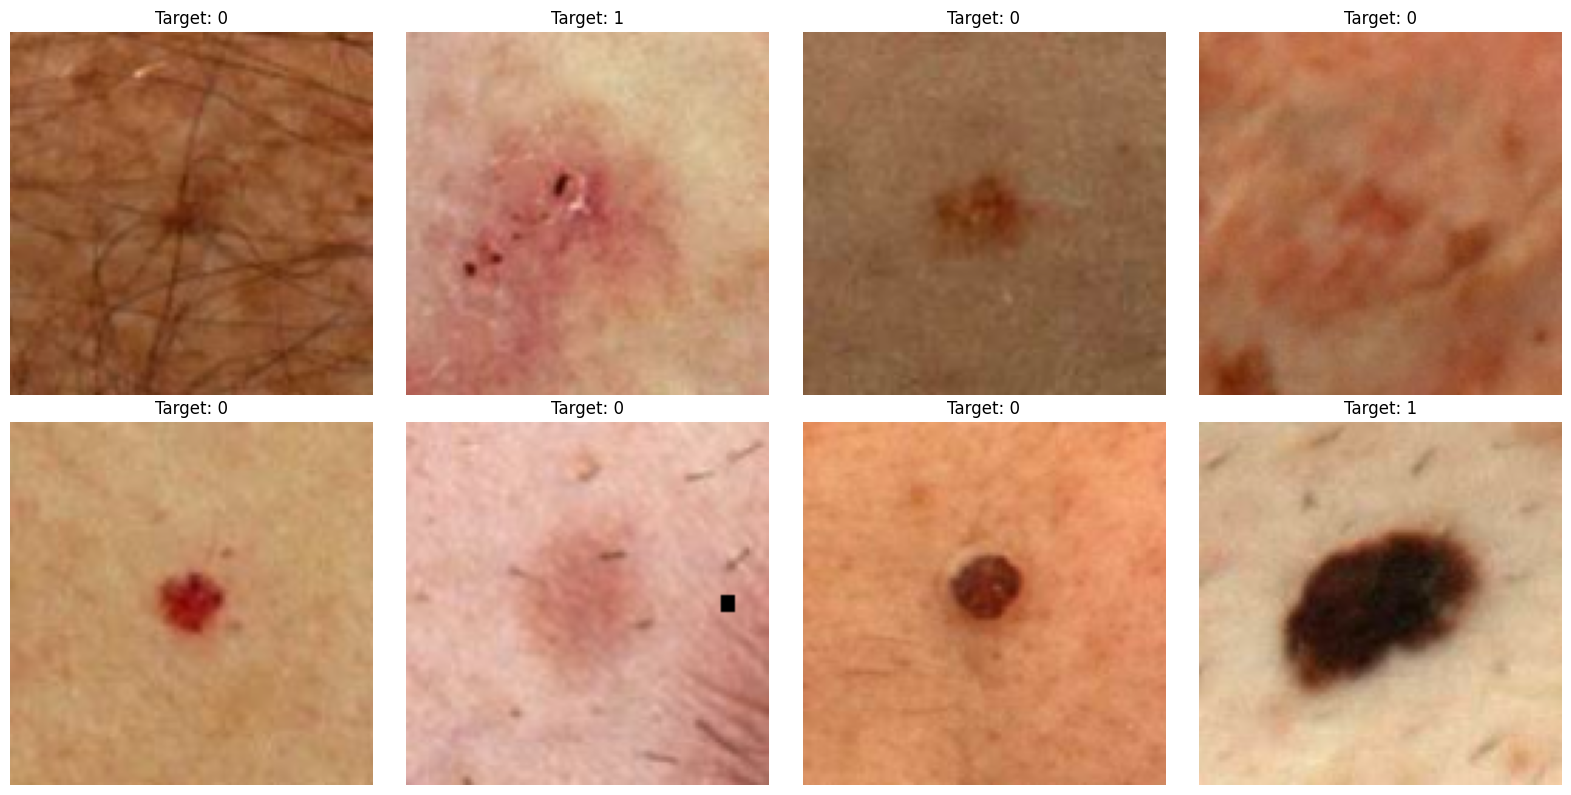

In [26]:
inputs, targets = next(iter(training_ds))
images = inputs["images"]
num_images, NUMERIC_COLUMNS = 8, 4

plt.figure(figsize=(4 * NUMERIC_COLUMNS, num_images // NUMERIC_COLUMNS * 4))
for i, (image, target) in enumerate(zip(images[:num_images], targets[:num_images])):
    plt.subplot(num_images // NUMERIC_COLUMNS, NUMERIC_COLUMNS, i + 1)
    image = image.numpy().astype("float32")
    target= target.numpy().astype("int32")[0]
    
    image = (image - image.min()) / (image.max() + 1e-4)

    plt.imshow(image)
    plt.title(f"Target: {target}")
    plt.axis("off")

plt.tight_layout()
plt.show()

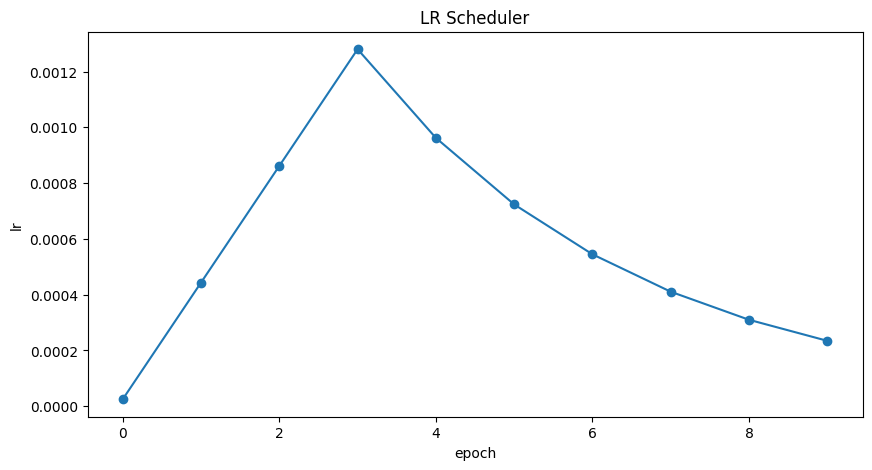

In [27]:
lr_cb = get_lr_callback(CFG.batch_size, mode="exp", plot=True)

💾 | Model Checkpoint¶

The ModelCheckpoint callback is used to save the model during training. It monitors the performance of the model on the validation data and saves the model with the best performance based on a specified metric.

Following setup ensures that the model with the highest validation AUC (val_auc) during training is saved to the file best_model.keras. Only the best model is saved, preventing overwriting with worse-performing models.

In [28]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_auc",    # Metric to monitor (validation AUC in this case).
    save_best_only=True,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)

🚂 | Training

Following cell will train the prepared model. Notice that, class_weight is used in the training.

In [29]:
history = model.fit(
    training_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    validation_data=validation_ds,
    verbose=CFG.verbose,
    class_weight=class_weights,
)

Epoch 1/8


: 

: 

: 

Visualize AUC with Epochs

In [ ]:
# Extract AUC and validation AUC from history
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)

# Find the epoch with the maximum val_auc
max_val_auc_epoch = np.argmax(val_auc)
max_val_auc = val_auc[max_val_auc_epoch]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, auc, 'o-', label='Training AUC', markersize=5, color='tab:blue')
plt.plot(epochs, val_auc, 's-', label='Validation AUC', markersize=5, color='tab:orange')

# Highlight the max val_auc
plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val AUC: {max_val_auc:.4f}')
plt.annotate(f'Max Val AUC: {max_val_auc:.4f}', 
             xy=(max_val_auc_epoch + 1, max_val_auc), 
             xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             color='tab:red')

# Enhancing the plot
plt.title('AUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)

# Show the plot
plt.show()

📋 | Result

In [ ]:
# Best Result
best_score = max(history.history['val_auc'])
best_epoch = np.argmax(history.history['val_auc']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

🧪 | Prediction

Load Best Model

In [ ]:
model.load_weights("best_model.keras")

Build Testing Dataset

Don't forget to normalize for the testing data as well.

In [ ]:
# Testing
print("# Testing:")
testing_features = dict(testing_df[FEAT_COLS])
testing_ids = testing_df.isic_id.values
testing_ds = build_dataset(testing_ids, testing_hdf5,
                        testing_features, batch_size=CFG.batch_size,
                         shuffle=False, augment=False, cache=False)
# Apply feature space processing
testing_ds = testing_ds.map(
    lambda x: {"images": x["images"],
               "features": feature_space(x["features"])}, num_parallel_calls=tf.data.AUTOTUNE)

Inference

In [ ]:
preds = model.predict(testing_ds).squeeze()

Check Prediction

In [ ]:
inputs = next(iter(testing_ds))
images = inputs["images"]

# Plotting
plt.figure(figsize=(10, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, i+1th subplot
    plt.imshow(images[i])  # Show image
    plt.title(f'Prediction: {preds[i]:.2f}')  # Set title with prediction
    plt.axis('off')  # Hide axis

plt.suptitle('Model Predictions on Testing Images', fontsize=16)
plt.tight_layout()
plt.show()

📩 | Submission

In [ ]:
pred_df = testing_df[["isic_id"]].copy()
pred_df["target"] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["isic_id"]].copy()
sub_df = sub_df.merge(pred_df, on="isic_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()